# DroughtScope

**LATITUDO 40** Team

**Antonio Elia Pascarella**: PhD Student in Artificial Intelligence for the Environment at University of Naples Federico II
**Mattia Rigiroli**: Data Scientist at Latitudo 40, PhD Student in Multispectral and Hyperspectral image analysis for urban sustainability at University of Genova
**Giovanni Giacco**: CTO at Latitudo 40, PhD Student in AI in Earth Observation at University of Naples Federico II
**Donato Amitrano**: Head of Research and Development at Latitudo 40, Researcher at Italian Aerospace Research
**Paolo De Piano**: Data Scientist and Remote Sensing Specialist at Latitudo 40

# 1. Executive Summary

This project aims at the development of a **decision support system** helping **public and private agrifood decision makers** in the optimization of water resource management. Our solution provides **early warnings** about **crop water stress** based on the estimate of the evaporative stress index (**ESI**), which is one of the most important indicators of stress conditions identified in literature.

**Main innovations**
- Original deep learning architecture to infer information typically contained in the thermal domain from the near infrared one
- Real-time onboard estimates thanks to lightweight processing
- Multi-task architecture for ESI estimation and LULC mapping

**Benefits for users/stakeholders**
- Optimization of water resources management to tackle with increasing water scarcity
- Possibility to implement local actions based on daily warning maps
- Optimization of food production
- Reduction of costs and resources employed for field monitoring

**Benefits for the scientific community**
- Availability of new data with better resolution of the ones today available provided by the ECOSTRESS mission
- Daily LULC maps to tackle with high-dynamic phenomena (river mobility, sedimentation, deforestation)

**A bit of context**

Climate change poses new challenges to the food industry, which is required to optimise production in terms of quantity and quality of products against reduced water and land availability due to increased periods of drought and urbanisation. The availability of accurate and real-time information about ET is expected to improve decision-making concerning the optimisation of agricultural practice by properly allocating the resources needed. In this regard, the idea of using real-time ET estimates has a significant societal value, as it contributes to **sustainable agriculture**, **food security**, **water conservation**, and **climate change adaptation**. The envisioned business model includes data-driven agricultural consulting services, a subscription-based platform and partnerships with agritech companies.

Evapotranspiration (ET) data helps irrigation planning and therefore is a powerful tool for the management of land and water resources. Water scarcity makes knowledge of crop water consumption essential for water budgeting of connected ecosystems like agriculture, industry and cities. In a context in which severe
droughts induce farmers to change crop typology to face reduced water availability, even in areas historically characterised by water abundance, offline processing of satellite data can result in delayed or sub-optimal decision-making. Timely information about the status of the cultivations can dramatically reduce water consumption, leading to cost savings, increased quality and quantity of food production and profitability. In this context, exploiting pre-trained models is an enabling factor for onboard processing, which is not feasible for direct retrieval of ET from measured brightness temperature via computationally expensive radiative transfer models.

**Data**

This research will exploit L1C data from the IMAGIN-e hyperspectral (HS) sensor, which features 50 spectral bands within the range [450,950] nm with a spatial resolution of 45 metres. The primary data source will be integrated with auxiliary data useful for the classification of agricultural lands, for which ET will be retrieved. To this end, we plan to use the ESA WorldCover dataset as ground truth. ECOSTRESS data will serve as a reference for ET in model training. ECOSTRESS
provides ET data based on the Priestley-Taylor Jet Propulsion Laboratory (PT-JPL) method, with a spatial resolution of approximately 70 metres, which will be rescaled to 45 metres for consistency with input HS data.

**Architecture Overview**

We have developed a **multi-task neural architecture** processes a hyperspectral tensor for Land Use Land Cover (LULC) mapping and Evaporative Stress Index (ESI) estimation. An **encoder** network creates a high-level embedding, used by **two decoders**. The first, trained with a cross-entropy loss function, generates a LULC map. The second, employing a Mean Absolute Error function, predicts the ESI map. The total loss is calculated from both tasks, optimizing them simultaneously. The shared representation learning used enhances efficiency and generalization.


<img title="Multi-Task NN for ESI Estimation" alt="Multi-Task NN for ESI Estimation" src="images/network_architecture.png">

**State of the Art**

ET is the process by which mass/energy is exchanged between the surface and the atmosphere through evaporating moisture from soil, open water and plant canopies. In agriculture, ET estimates are used to monitor droughts, manage irrigation and assess crop water content. Due to the unreliability of the scaling of in-situ measurements, the analysis of remote sensing data is today the state-of-the-art in the study of ET. In this context, hyperspectral remote sensing represents a promising data source as it allows for a detailed study of the spectral response of soils and vegetation canopies. The literature already highlighted the correlation between narrowband indices and ET [1]. The objective of this project is to exploit a combination of several hyperspectral variables in modern machine learning or deep learning environments [2] and to deliver an onboard, real-time processing framework able to predict ET at plot scale.

**[1]** M. Marshall, P. Thenkabail, T. Biggs, K. Post, “Hyperspectral narrowband and multispectral broadband indices for remote sensing of crop evapotranspiration and its components (transpiration and soil evaporation)”, Agricultural and Forest Meteorology, vol. 218-219, pp. 122-134, 2016

**[2]** D. Amitrano, L. Cicala, M. De Mizio, F. Tufano, “UAV Hyperspectral Characterization of Vegetation Using Entropy-Based Active Sampling for Partial Least Square Regression Models”, Applied Sciences, vol. 13, no. 8, pp. 4812, 2023

# 2. Imports and code dependencies

In [100]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import math
import time  # Importa il modulo time

In [2]:
import rioxarray as rxr
import rasterio
import geopandas as gpd
from matplotlib import pyplot as plt

In [3]:
import shapely
import shapely.wkt as wkt

In [38]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Set the seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
# filter out some SHDeprecationWarnings
import warnings

warnings.filterwarnings("ignore")

In [6]:
def get_bbox_from_aoi(aoi):
    aoi_wkt = wkt.loads(aoi) if isinstance(aoi, str) else aoi
    bounds_left, bounds_bottom, bounds_right, bounds_top = aoi_wkt.bounds
    bbox = shapely.Polygon(
        [
            [bounds_left, bounds_bottom],
            [bounds_left, bounds_top],
            [bounds_right, bounds_top],
            [bounds_right, bounds_bottom],
        ]
    )
    return list(bbox.bounds)


def get_geometry_from_aoi(aoi: str) -> shapely.Geometry:
    aoi_wkt = wkt.loads(aoi)
    return aoi_wkt

# 3. Input/Output data and example training labels (if applicable)

### Dataset (hsi, esi, lulc)


Imports 14 stacks sampled from all over the world, where the input tensors are the 50-band hyperspectral images while the output tensors are the two-channel tensors representing one Evaporative stress index (Esi) and another a label identifying crop or not crop

Spiegare come abbiamo creato gli stack in modo semi-manuale e mettere referenze dei dati

LULC 2021, ESI più vicina alle immagine iperspettrale

https://worldcover2021.esa.int/

### AOI Selection

Since the process to retrieve Ground Truth data for labels was not automated, we performed the analysis on a sample of patches in Europe for which we retrieved the data manually. Here we show the original dataset given for the challenge and our selected patches!

In [89]:
hsi_prisma_locations = gpd.read_file("data/hsi-prisma-locations.gpkg")
WORLD_GDF = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

<Axes: >

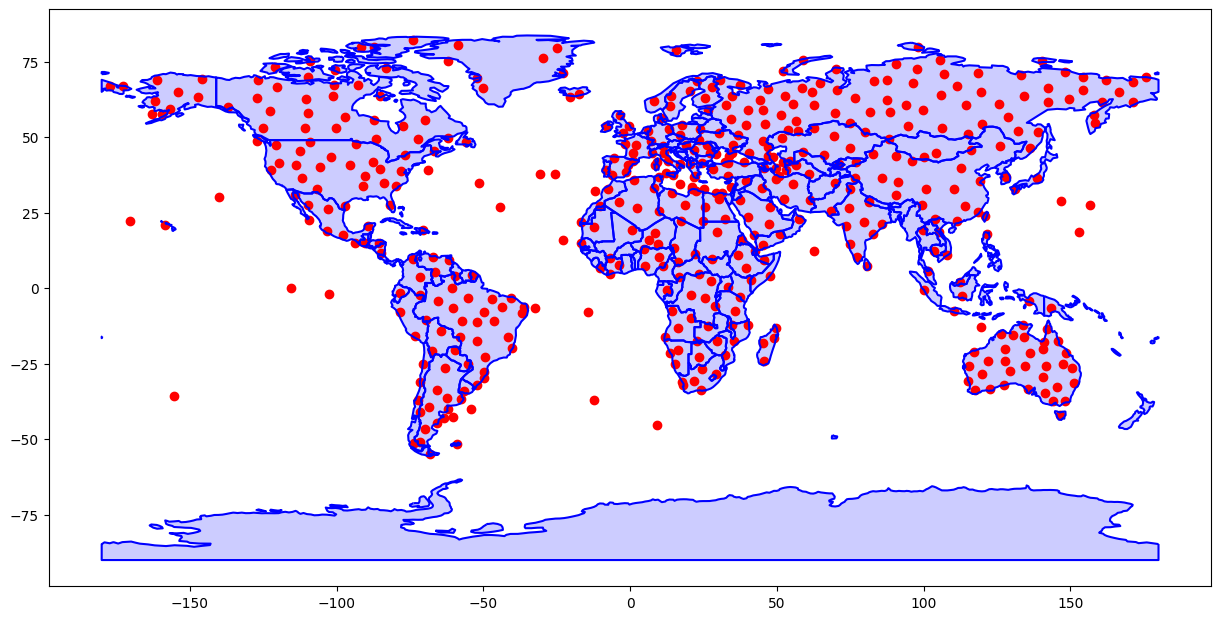

In [90]:
fig, ax = plt.subplots(figsize=(15, 10))
WORLD_GDF.plot(ax=ax, color="b", alpha=0.2)
WORLD_GDF.boundary.plot(ax=ax, color="b")
hsi_prisma_locations.plot(ax=ax, color="r")

In [91]:
hsi_prisma_locations.head()

,cloud_cover,filename,date,order_id,geometry
0,0.000998,PRS_L1_STD_OFFL_20200924074020_20200924074024_...,24/09/2020,36765,POINT (53.70690 52.46040)
1,0.024464,PRS_L1_STD_OFFL_20210629073006_20210629073010_...,29/06/2021,36830,POINT (56.35450 55.34120)
2,0.000000,PRS_L1_STD_OFFL_20220827074222_20220827074226_...,27/08/2022,36839,POINT (55.63770 60.95850)
3,0.000000,PRS_L1_STD_OFFL_20210706074713_20210706074717_...,06/07/2021,36874,POINT (58.71460 66.10830)
4,4.225590,PRS_L1_STD_OFFL_20210622084113_20210622084118_...,22/06/2021,36875,POINT (59.01930 75.41460)


In [92]:
#selected_patches_ids = [int(x.split("/")[1].split("_")[0]) for x in glob.glob("data/*.tif")]
selected_patches_ids = [30, 38, 39, 41, 43, 47, 95]
hsi_prisma_locations = hsi_prisma_locations.reset_index()
selected_points = hsi_prisma_locations.loc[hsi_prisma_locations['index'].isin(selected_patches_ids)]

In [93]:
selected_points

,index,cloud_cover,filename,date,order_id,geometry
30,30,0.006922,PRS_L1_STD_OFFL_20210619093633_20210619093637_...,19/06/2021,38090,POINT (21.73000 45.64710)
38,38,0.002956,PRS_L1_STD_OFFL_20210915095325_20210915095329_...,15/09/2021,38096,POINT (18.90900 47.28280)
39,39,0.236389,PRS_L1_STD_OFFL_20211010102219_20211010102223_...,10/10/2021,38188,POINT (13.30000 52.55960)
41,41,0.013455,PRS_L1_STD_OFFL_20210717105518_20210717105523_...,17/07/2021,38185,POINT (5.94020 52.08530)
43,43,0.002344,PRS_L1_STD_OFFL_20210628103129_20210628103134_...,28/06/2021,38189,POINT (8.61320 40.70750)
47,47,0.001121,PRS_L1_STD_OFFL_20210724094132_20210724094137_...,24/07/2021,38192,POINT (16.89710 41.03500)
95,95,0.004883,PRS_L1_STD_OFFL_20210223111357_20210223111402_...,23/02/2021,38449,POINT (-1.84767 47.69850)


<Axes: >

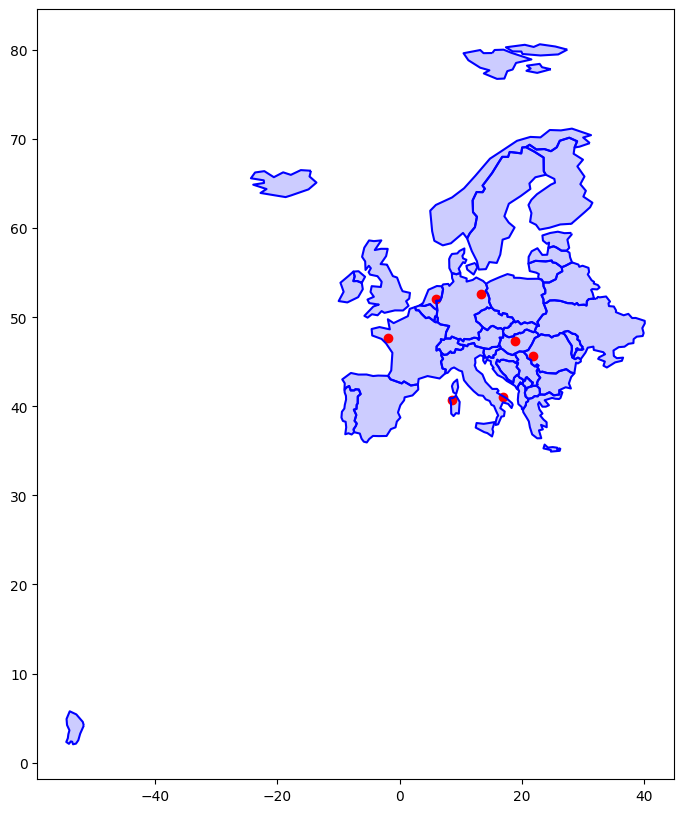

In [95]:
WORLD_GDF_eu = WORLD_GDF[WORLD_GDF["continent"]=="Europe"]
WORLD_GDF_eu = WORLD_GDF_eu.loc[~WORLD_GDF_eu['iso_a3'].isin(["RUS"])] # To have a compact view
fig, ax = plt.subplots(figsize=(15, 10))
WORLD_GDF_eu.plot(ax=ax, color="b", alpha=0.2)
WORLD_GDF_eu.boundary.plot(ax=ax, color="b")
selected_points.plot(ax=ax, color="r")

To avoid noise in this few data, we selected AOI with a cloud coverage near to 0.

In [88]:
selected_points.cloud_cover

30    0.006922
38    0.002956
39    0.236389
41    0.013455
43    0.002344
47    0.001121
95    0.004883
Name: cloud_cover, dtype: float64

### Plot same sample data raw data

In [13]:
sample_data = rxr.open_rasterio("data/38_stacked.tif")

In [14]:
sample_area = get_geometry_from_aoi("Polygon ((336150.56508310226490721 5230573.17958063818514347, "
                                    "351950.32561923412140459 5230156.27668263670057058, "
                                    "352329.36321769654750824 5245271.61154528148472309, "
                                    "336570.08717306260950863 5245688.35888818092644215, "
                                    "336150.56508310226490721 5230573.17958063818514347))")

In [140]:
sample_data = sample_data.rio.clip([shapely.geometry.mapping(sample_area)], crs=32634, all_touched=True)
sample_data = sample_data.rio.write_nodata(np.nan)
sample_data = sample_data.where(sample_data != 0)

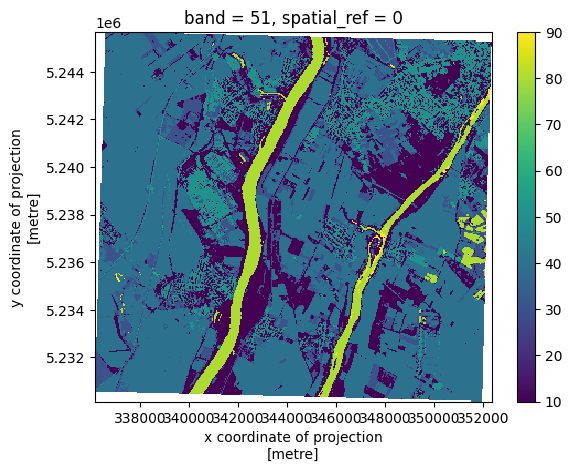

In [139]:
sample_data[50].plot() # LULC

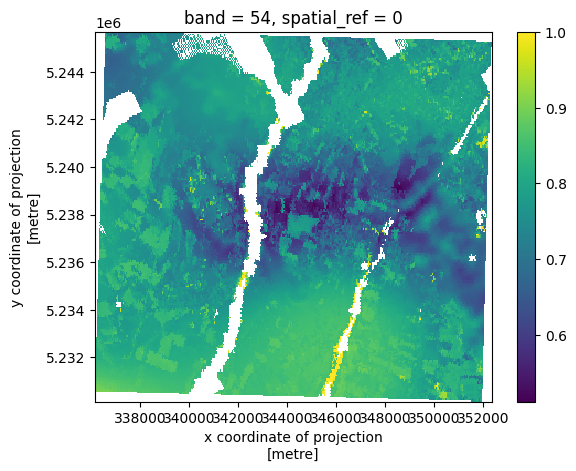

In [385]:
sample_data[53].plot() #ESI

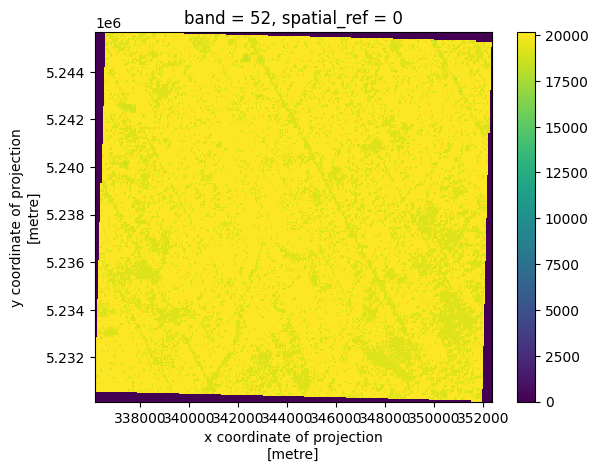

In [25]:
sample_data[51].plot() #QC

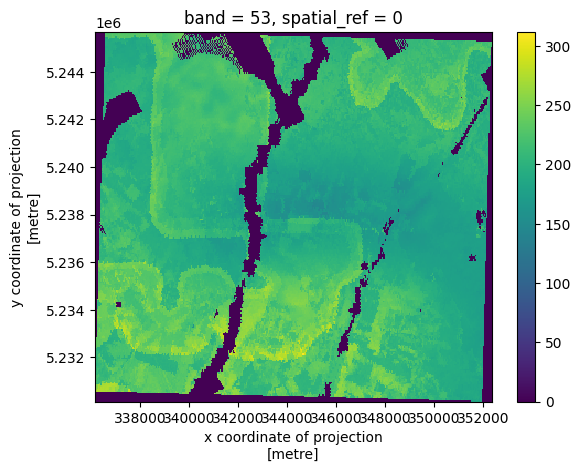

In [132]:
sample_data[52].plot() #Evapotranspiration

In [131]:
sample_data = sample_data.rio.write_nodata(0, encoded=True)

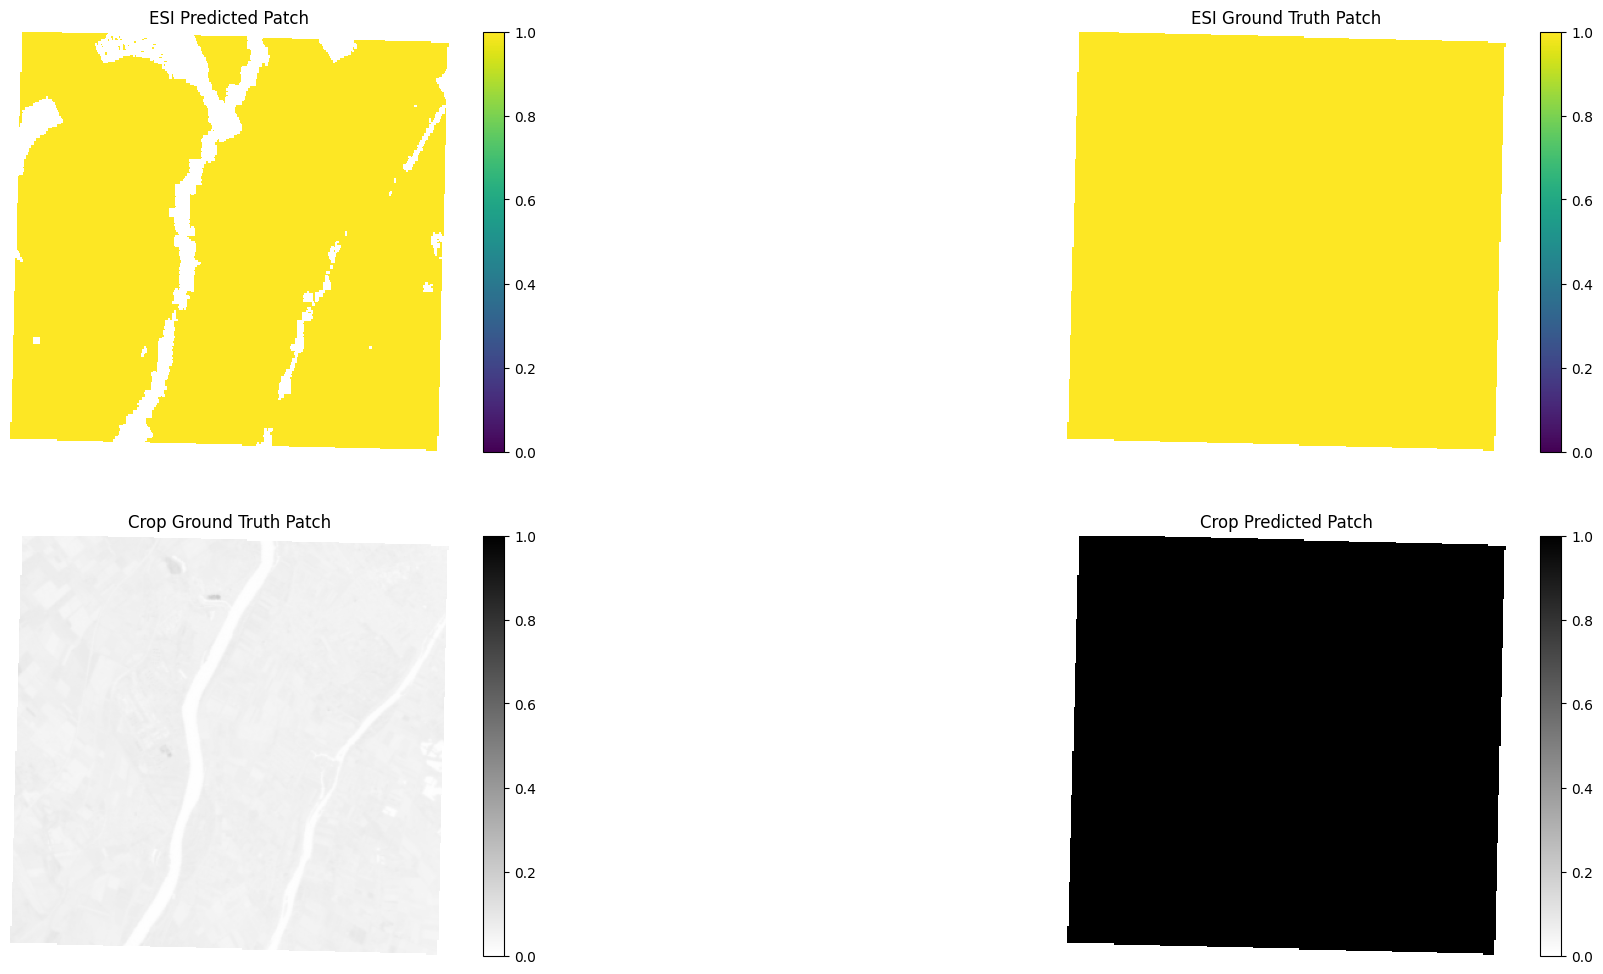

In [141]:
fig, axs = plt.subplots(2, 2, figsize=(25, 12))

# Create a custom colormap that displays NaN values as white
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # NaN as white

# ESI Predicted
im_esi_pred = axs[0, 0].imshow(sample_data[52], cmap='viridis', vmin=0, vmax=1)
axs[0, 0].set_title(f"ESI Predicted Patch")
axs[0, 0].axis('off')
fig.colorbar(im_esi_pred, ax=axs[0, 0], orientation='vertical', fraction=0.046, pad=0.04)

# ESI Ground Truth
im_esi_gt = axs[0, 1].imshow(sample_data[51], cmap='viridis', vmin=0, vmax=1)
axs[0, 1].set_title(f"ESI Ground Truth Patch")
axs[0, 1].axis('off')
fig.colorbar(im_esi_gt, ax=axs[0, 1], orientation='vertical', fraction=0.046, pad=0.04)

# Crop Predicted
im_crop_pred = axs[1, 1].imshow(sample_data[50], cmap='gray_r', vmin=0, vmax=1)
axs[1, 1].set_title(f"Crop Predicted Patch")
axs[1, 1].axis('off')
fig.colorbar(im_crop_pred, ax=axs[1, 1], orientation='vertical', fraction=0.046, pad=0.04)

# Crop Ground Truth
im_crop_gt = axs[1, 0].imshow(sample_data[49], cmap='gray_r', vmin=0, vmax=1)
axs[1, 0].set_title(f"Crop Ground Truth Patch")
axs[1, 0].axis('off')
fig.colorbar(im_crop_gt, ax=axs[1, 0], orientation='vertical', fraction=0.046, pad=0.04)

### Reading data from .tif files

In [26]:
def read_data(paths):

    X_list = []
    y_list = []

    for path in paths:
        with rasterio.open(path) as dataset:
            raster_array = dataset.read()

        # Select the hyperspectral bands (X)
        selected_channels = raster_array[:50]
        X = np.transpose(selected_channels, (1, 2, 0))
        X = np.expand_dims(X, axis=0)

        # Select the target variables (ESI, LULC)
        last_channel = raster_array[[-4, -1]]
        last_channel = np.transpose(last_channel, (1, 2, 0))
        y = np.expand_dims(last_channel, axis=0)

        X_list.append(X)
        y_list.append(y)

    return X_list, y_list

In [27]:
# List of paths for stacks
raster_paths = [
    "data/30_stacked.tif",
    "data/38_stacked.tif",
    "data/39_stacked.tif",
    "data/41_stacked.tif",
    "data/43_stacked.tif",
    "data/47_stacked.tif",
    "data/95_stacked.tif"
]

X, y = read_data(raster_paths)

# Print the size of the arrays
for i, (X_i, y_i) in enumerate(zip(X, y)):
    print(f"Shape di X{i+1}: {X_i.shape}")
    print(f"Shape di y{i+1}: {y_i.shape}")

Shape di X1: (1, 804, 806, 50)
Shape di y1: (1, 804, 806, 2)
Shape di X2: (1, 839, 830, 50)
Shape di y2: (1, 839, 830, 2)
Shape di X3: (1, 840, 836, 50)
Shape di y3: (1, 840, 836, 2)
Shape di X4: (1, 822, 856, 50)
Shape di y4: (1, 822, 856, 2)
Shape di X5: (1, 834, 885, 50)
Shape di y5: (1, 834, 885, 2)
Shape di X6: (1, 787, 830, 50)
Shape di y6: (1, 787, 830, 2)
Shape di X7: (1, 806, 804, 50)
Shape di y7: (1, 806, 804, 2)


### Splitting data in patches

In [28]:
def create_patches(X_tensor, target_tensor, patch_size=32):
    """Create non-overlapping sub-patches from the tensors X_tensor and target_tensor.

    Args:
        X_tensor (ndarray): Input tensors with dimensions (batch, height, width, channels).
        target_tensor (ndarray): Target tensors with dimensions (batch, height, width, 1).
        patch_size (int): Size of the sub-patches.

    Returns:
        X_tensor_patches (ndarray): Sub-patch tensors of X_tensor with dimensions (number_patches, patch_size, patch_size, channels).
        target_tensor_patches (ndarray): Sub-patch tensors of target_tensor with dimensions (number_patches, patch_size, patch_size, 1).
    """

    # Check that the number of samples is equal in both tensors
    assert X_tensor.shape[0] == target_tensor.shape[0], "The number of samples in the X_tensor and target_tensor tensors is not equal."

    # Calculate the number of subpatches for sample
    num_patches_per_sample = (X_tensor.shape[1] // patch_size) * (X_tensor.shape[2] // patch_size)

    # Calculate the total number of subpatches
    num_patches = X_tensor.shape[0] * num_patches_per_sample

    # Initialize subpatch tensors
    X_tensor_patches = np.zeros((num_patches, patch_size, patch_size, X_tensor.shape[3]), dtype=X_tensor.dtype)
    target_tensor_patches = np.zeros((num_patches, patch_size, patch_size, target_tensor.shape[3]), dtype=target_tensor.dtype)

    # Create subpatches for each sample
    patch_idx = 0
    for sample_idx in range(X_tensor.shape[0]):
        for i in range(X_tensor.shape[1] // patch_size):
            for j in range(X_tensor.shape[2] // patch_size):
                x_start = i * patch_size
                x_end = (i + 1) * patch_size
                y_start = j * patch_size
                y_end = (j + 1) * patch_size

                X_tensor_patches[patch_idx] = X_tensor[sample_idx, x_start:x_end, y_start:y_end, :]
                target_tensor_patches[patch_idx] = target_tensor[sample_idx, x_start:x_end, y_start:y_end, :]

                patch_idx += 1

    return X_tensor_patches, target_tensor_patches

In [29]:
X_patched = []
y_patched = []

for X_i, y_i in zip(X, y):
    patches_X_i, patches_y_i = create_patches(X_i, y_i, patch_size=32)
    X_patched.append(patches_X_i)
    y_patched.append(patches_y_i)

# Print the size of the patch arrays
for i, (patches_X_i, patches_y_i) in enumerate(zip(X_patched, y_patched)):
    print(f"Shape di X_patches{i+1}: {patches_X_i.shape}")
    print(f"Shape di y_patches{i+1}: {patches_y_i.shape}")

Shape di X_patches1: (625, 32, 32, 50)
Shape di y_patches1: (625, 32, 32, 2)
Shape di X_patches2: (650, 32, 32, 50)
Shape di y_patches2: (650, 32, 32, 2)
Shape di X_patches3: (676, 32, 32, 50)
Shape di y_patches3: (676, 32, 32, 2)
Shape di X_patches4: (650, 32, 32, 50)
Shape di y_patches4: (650, 32, 32, 2)
Shape di X_patches5: (702, 32, 32, 50)
Shape di y_patches5: (702, 32, 32, 2)
Shape di X_patches6: (600, 32, 32, 50)
Shape di y_patches6: (600, 32, 32, 2)
Shape di X_patches7: (625, 32, 32, 50)
Shape di y_patches7: (625, 32, 32, 2)


## Filter patches with NaNs

In [30]:
# Concatenate all the patches from the different stacks, creating one tensor for the patch inputs and one for the outputs
X = np.concatenate(X_patched, axis=0)
y = np.concatenate(y_patched, axis=0)

print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

Shape di X: (4528, 32, 32, 50)
Shape di y: (4528, 32, 32, 2)


In [31]:
# Remove both input and target patches with NaNs
nan_mask = np.any(np.isnan(X), axis=(1, 2, 3))

# Filter X by removing patches with NaN values
X = X[~nan_mask]
y = y[~nan_mask]


print("Shape of X without NaN in input patches:", X.shape)
print("Shape of y without NaN in input patches:", y.shape)

# Check if there are NaN values in each target patch
nan_mask = np.any(np.isnan(y), axis=(1, 2, 3))

# Filter X by removing patches with NaN values
X = X[~nan_mask]
y = y[~nan_mask]


print("Shape of X with no NaN in target patches:", X.shape)
print("Shape of y without NaN in target patches:", y.shape)

Shape of X without NaN in input patches: (2696, 32, 32, 50)
Shape of y without NaN in input patches: (2696, 32, 32, 2)
Shape of X with no NaN in target patches: (2231, 32, 32, 50)
Shape of y without NaN in target patches: (2231, 32, 32, 2)


## Create a Custom Dataset class and instantiate the dataset class and dataloader for train, val and test (hold-out: 70-15-15)

In [220]:
# Split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=17)

# Split temp into valid and test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17)

# Continue with your existing preprocessing
X_train, X_valid, X_test = map(lambda x: np.clip(np.nan_to_num(x, copy=True, nan=-1.0), a_min=-1, a_max=None), [X_train, X_valid, X_test])

im_height = X_train.shape[1]
im_width = X_train.shape[2]
im_depth = X_train.shape[3]

# Converting X to channel-first
X_train, X_valid, X_test = map(lambda x: np.transpose(x, (0, 3, 1, 2)), [X_train, X_valid, X_test])

# Divide y in 2 targets
y1_train, y2_train = y_train[:,:,:,0], y_train[:,:,:,1]
y1_valid, y2_valid = y_valid[:,:,:,0], y_valid[:,:,:,1]
y1_test, y2_test = y_test[:,:,:,0], y_test[:,:,:,1]

# Map Lulc in [0,1] --> Non Crop / Crop
mapping = {10.0:0, 20.0:0, 30.0:0, 40.0:1, 50.0:0, 60.0:0, 80.0:0, 90.0:0}

y1_train, y1_valid, y1_test = map(lambda x: np.vectorize(mapping.get)(x), [y1_train, y1_valid, y1_test])

# Converting y to channel-first and reshaping target tensor
y1_train, y2_train = y1_train.reshape(y1_train.shape[0],  y1_train.shape[1], y1_train.shape[2]), y2_train.reshape(y2_train.shape[0], 1, y2_train.shape[1], y2_train.shape[2])
y1_valid, y2_valid = y1_valid.reshape(y1_valid.shape[0],  y1_valid.shape[1], y1_valid.shape[2]), y2_valid.reshape(y2_valid.shape[0], 1, y2_valid.shape[1], y2_valid.shape[2])
y1_test, y2_test = y1_test.reshape(y1_test.shape[0],  y1_test.shape[1], y1_test.shape[2]), y2_test.reshape(y2_test.shape[0], 1, y2_test.shape[1], y2_test.shape[2])

# Converting to PyTorch tensors
X_train, y1_train, y2_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y1_train, dtype=torch.float32), torch.tensor(y2_train, dtype=torch.float32)
X_valid, y1_valid, y2_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y1_valid, dtype=torch.float32), torch.tensor(y2_valid, dtype=torch.float32)
X_test, y1_test, y2_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y1_test, dtype=torch.float32), torch.tensor(y2_test, dtype=torch.float32)

class CustomDataset(Dataset):
    def __init__(self, X, y1, y2):
        self.X = X
        self.y1 = y1
        self.y2 = y2

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y1[idx], self.y2[idx]

train_ds = CustomDataset(X_train, y1_train, y2_train)
valid_ds = CustomDataset(X_valid, y1_valid, y2_valid)
test_ds = CustomDataset(X_test, y1_test, y2_test)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

In [221]:
unique, counts = np.unique(y1_train, return_counts=True)
frequency = dict(zip(unique, counts))
print(frequency)

{0.0: 1174402, 1.0: 424062}


## Plot same sample patch

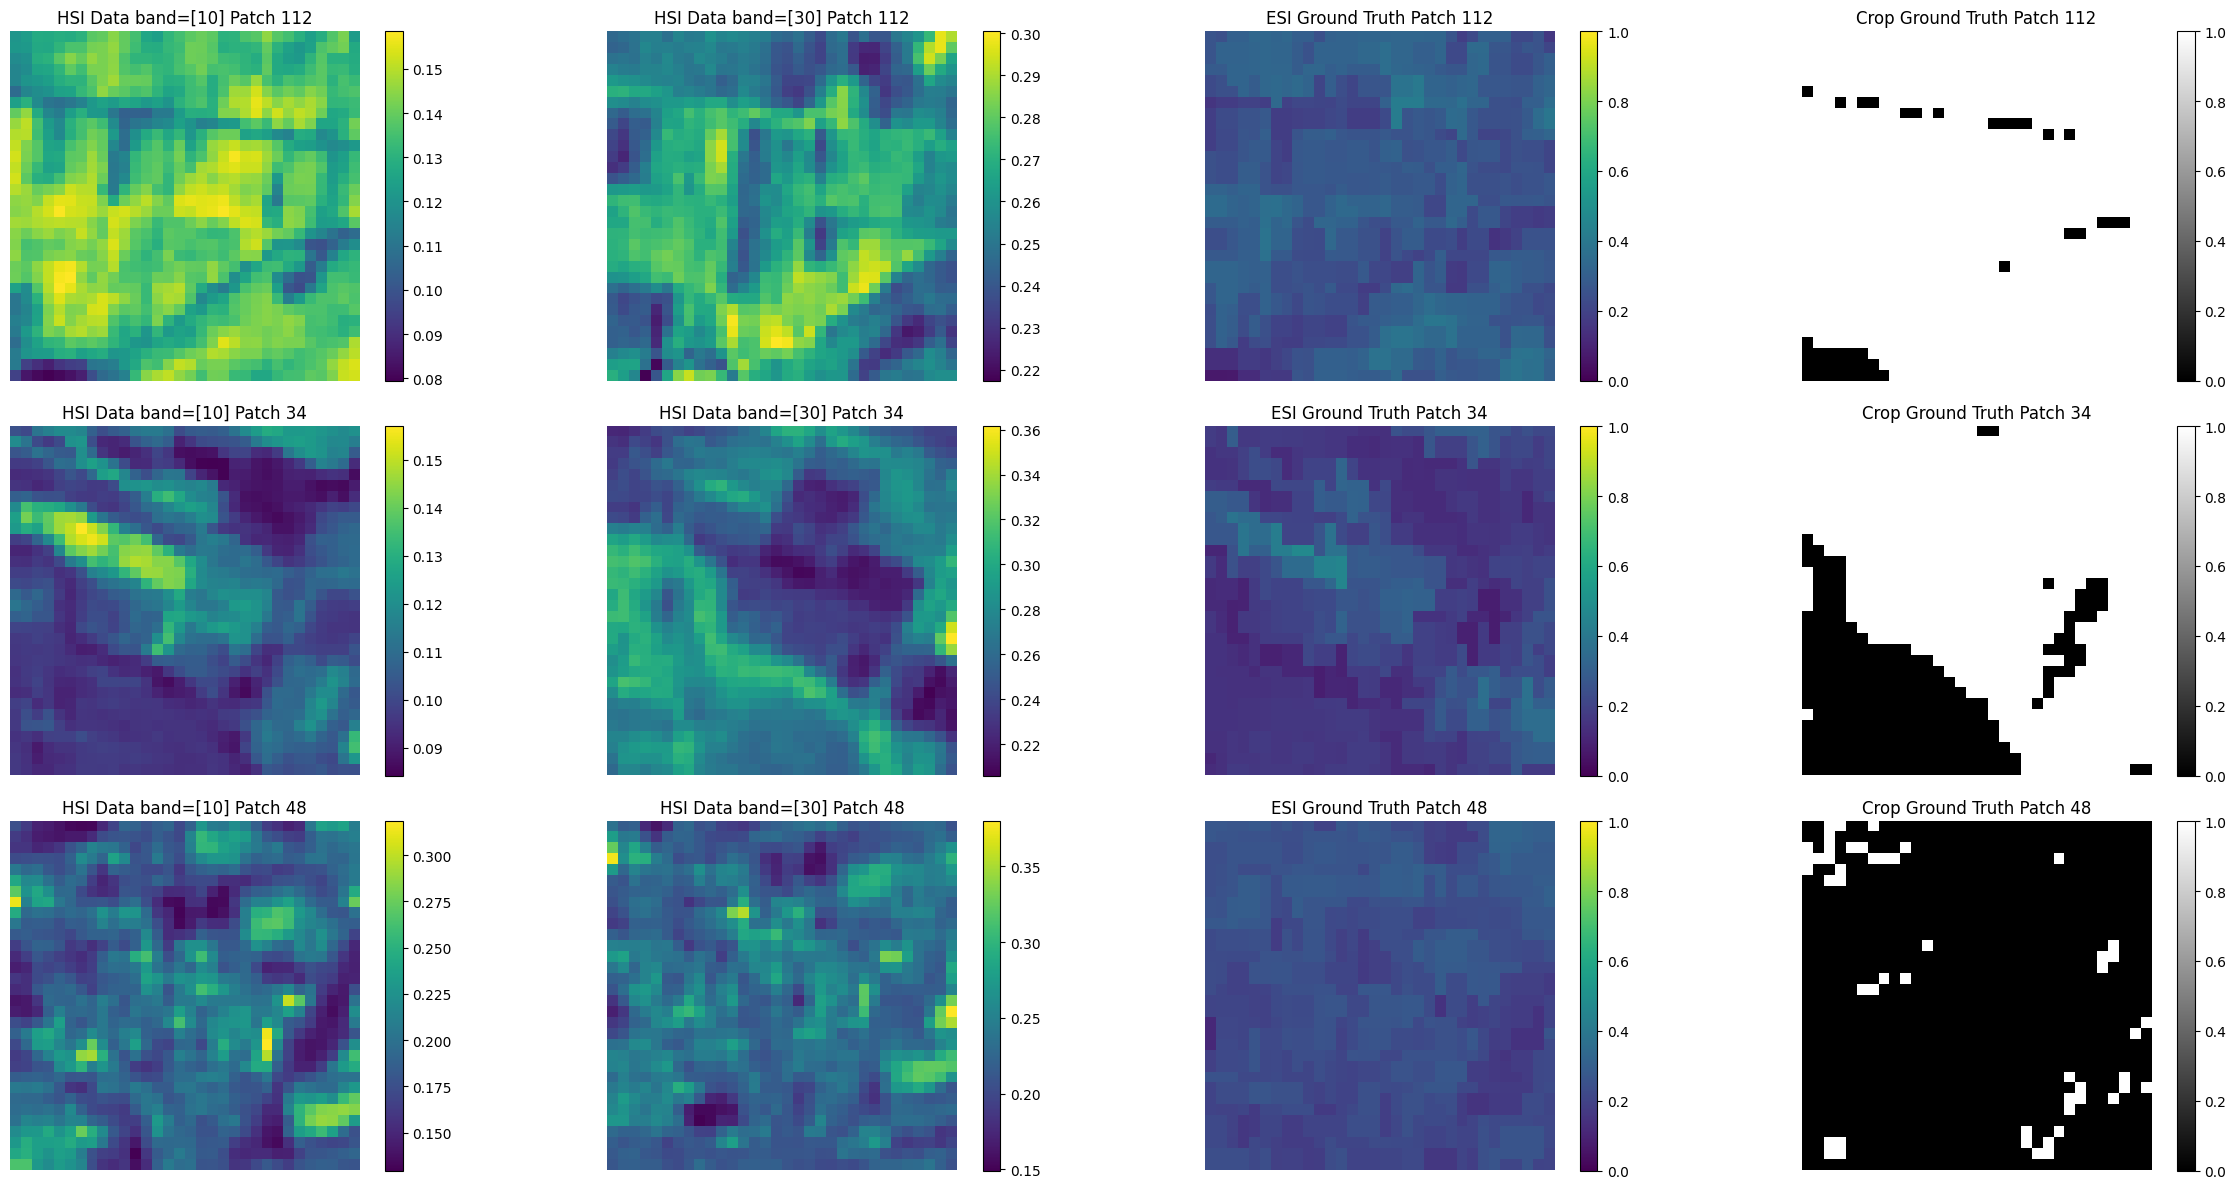

In [117]:
# Randomly sample 4 unique indices
random_indices = [111, 33, 47]

hsi_data = X_test[random_indices].squeeze().cpu().numpy()
esi_ground_truth = y2_test[random_indices].squeeze().cpu().numpy()
crop_ground_truth = y1_test[random_indices].cpu().numpy()

# Create a figure and axes for plotting
fig, axs = plt.subplots(3, 4, figsize=(25, 12))

# Create a custom colormap that displays NaN values as white
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # NaN as white

for i in range(3):

    # HSI
    im_hsi = axs[i, 0].imshow(hsi_data[i][10])
    axs[i, 0].set_title(f"HSI Data band=[10] Patch {random_indices[i] + 1}")
    axs[i, 0].axis('off')
    fig.colorbar(im_hsi, ax=axs[i, 0], orientation='vertical', fraction=0.046, pad=0.04)

    # HSI
    im_hsi2 = axs[i, 1].imshow(hsi_data[i][30])
    axs[i, 1].set_title(f"HSI Data band=[30] Patch {random_indices[i] + 1}")
    axs[i, 1].axis('off')
    fig.colorbar(im_hsi2, ax=axs[i, 1], orientation='vertical', fraction=0.046, pad=0.04)

    # ESI Ground Truth
    im_esi_gt = axs[i, 2].imshow(esi_ground_truth[i], cmap="viridis", vmin=0, vmax=1)
    axs[i, 2].set_title(f"ESI Ground Truth Patch {random_indices[i] + 1}")
    axs[i, 2].axis('off')
    fig.colorbar(im_esi_gt, ax=axs[i, 2], orientation='vertical', fraction=0.046, pad=0.04)

    # Crop Ground Truth
    im_crop_gt = axs[i, 3].imshow(crop_ground_truth[i], cmap='gray', vmin=0, vmax=1)
    axs[i, 3].set_title(f"Crop Ground Truth Patch {random_indices[i] + 1}")
    axs[i, 3].axis('off')
    fig.colorbar(im_crop_gt, ax=axs[i, 3], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# 4. Description of ML algorithm and training strategies

Model construction with a single **Encoder** which takes the **hyperspectral tensor as input**, produces a bottleneck and ends up in **two parallel decoders**: one which generates a regression on **Evaporative Stress Index (ESI)** and another which generates the **classification on crop/not crop**. In the code there is also a commented Unet with attention that was NOT used because the attention mechanisms are too computationally expensive for the context of the challenge.

## Network definition

In [102]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class PositionalEncoding2D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        if channels % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                             "odd dimension (got dim={:d})".format(channels))
        self.channels = channels
        self.dim = channels // 2
        div_term = torch.exp(torch.arange(0., self.dim, 2) *
                             -(math.log(10000.0) / self.dim))
        self.register_buffer('div_term', div_term)

    def forward(self, x):
        batch_size, _, height, width = x.size()

        pos_w = torch.arange(0., width).unsqueeze(1).to(x.device)
        pos_h = torch.arange(0., height).unsqueeze(1).to(x.device)

        pe = torch.zeros(self.channels, height, width, device=x.device)
        pe[0:self.dim:2, :, :] = torch.sin(pos_w * self.div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:self.dim:2, :, :] = torch.cos(pos_w * self.div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[self.dim::2, :, :] = torch.sin(pos_h * self.div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[self.dim + 1::2, :, :] = torch.cos(pos_h * self.div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

        pe = pe.unsqueeze(0).repeat(batch_size, 1, 1, 1)

        return x + pe

class SelfAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionBlock, self).__init__()
        self.self_attention = nn.MultiheadAttention(in_channels, num_heads=4)
        self.positional_encoding = PositionalEncoding2D(in_channels)            #PositionalEncoding

    def forward(self, x):
        x = self.positional_encoding(x)                                         #PositionalEncoding
        batch_size, num_features, height, width = x.size()
        x = x.permute(0, 2, 3, 1).flatten(1, 2).permute(1, 0, 2)
        attn_output, _ = self.self_attention(x, x, x)
        attn_output = attn_output.permute(1, 2, 0).view(batch_size, num_features, height, width)
        return attn_output

# class UNet(nn.Module): #con attention
#     def __init__(self):
#         super().__init__()
#         """ Encoder """
#         self.e1 = encoder_block(50, 64)
#         self.sa1 = SelfAttentionBlock(64)
#         self.e2 = encoder_block(64, 128)
#         self.sa2 = SelfAttentionBlock(128)
#         self.e3 = encoder_block(128, 256)
#         self.sa3 = SelfAttentionBlock(256)
#         self.e4 = encoder_block(256, 512)
#         self.sa4 = SelfAttentionBlock(512)
#         """ Bottleneck """
#         self.b = conv_block(512, 1024)
#         """ Decoder 1"""
#         self.d1_1 = decoder_block(1024, 512)
#         self.d2_1 = decoder_block(512, 256)
#         self.d3_1 = decoder_block(256, 128)
#         self.d4_1 = decoder_block(128, 64)
#         """ Decoder 2"""
#         self.d1_2 = decoder_block(1024, 512)
#         self.d2_2 = decoder_block(512, 256)
#         self.d3_2 = decoder_block(256, 128)
#         self.d4_2 = decoder_block(128, 64)
#         """ Outputs """
#         self.outputs1 = nn.Conv2d(64, 2, kernel_size=1, padding=0)  #considero 8 classi (da 0 a 1)
#         self.outputs2 = nn.Conv2d(64, 1, kernel_size=1, padding=0)

#     def forward(self, inputs):
#         """ Encoder """
#         s1, p1 = self.e1(inputs)
#         s1 = self.sa1(s1)
#         s2, p2 = self.e2(p1)
#         s2 = self.sa2(s2)
#         s3, p3 = self.e3(p2)
#         s3 = self.sa3(s3)
#         s4, p4 = self.e4(p3)
#         s4 = self.sa4(s4)
#         """ Bottleneck """
#         b = self.b(p4)
#         """ Decoder 1"""
#         d1_1 = self.d1_1(b, s4)
#         d2_1 = self.d2_1(d1_1, s3)
#         d3_1 = self.d3_1(d2_1, s2)
#         d4_1 = self.d4_1(d3_1, s1)
#         """ Decoder 2"""
#         d1_2 = self.d1_2(b, s4)
#         d2_2 = self.d2_2(d1_2, s3)
#         d3_2 = self.d3_2(d2_2, s2)
#         d4_2 = self.d4_2(d3_2, s1)
#         """ Outputs """
#         outputs1 = self.outputs1(d4_1)
#         outputs2 = self.outputs2(d4_2)
#         return outputs1, outputs2

class UNet(nn.Module): #without attention
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(50, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder 1"""
        self.d1_1 = decoder_block(1024, 512)
        self.d2_1 = decoder_block(512, 256)
        self.d3_1 = decoder_block(256, 128)
        self.d4_1 = decoder_block(128, 64)
        """ Decoder 2"""
        self.d1_2 = decoder_block(1024, 512)
        self.d2_2 = decoder_block(512, 256)
        self.d3_2 = decoder_block(256, 128)
        self.d4_2 = decoder_block(128, 64)
        """ Outputs """
        self.outputs1 = nn.Conv2d(64, 2, kernel_size=1, padding=0)  #here we have 2 classes (0 and 1) for LULC crop/not crop
        self.outputs2 = nn.Conv2d(64, 1, kernel_size=1, padding=0)  #ESI estimation

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder 1"""
        d1_1 = self.d1_1(b, s4)
        d2_1 = self.d2_1(d1_1, s3)
        d3_1 = self.d3_1(d2_1, s2)
        d4_1 = self.d4_1(d3_1, s1)
        """ Decoder 2"""
        d1_2 = self.d1_2(b, s4)
        d2_2 = self.d2_2(d1_2, s3)
        d3_2 = self.d3_2(d2_2, s2)
        d4_2 = self.d4_2(d3_2, s1)
        """ Outputs """
        outputs1 = self.outputs1(d4_1)
        outputs2 = self.outputs2(d4_2)
        return outputs1, outputs2

# Training function
def train(model, dataloader, optimizer, criterion1, criterion2, device):
    model.train()
    running_loss = 0.0
    for inputs, targets1, targets2 in dataloader:
        inputs = inputs.to(device)
        targets1 = targets1.to(device)
        targets2 = targets2.to(device)

        # forward pass
        outputs1, outputs2 = model(inputs)

        # Compute loss
        loss1 = criterion1(outputs1, targets1.long())
        loss2 = criterion2(outputs2, targets2)

        # The total loss here is the sum of 2 loss components
        loss = loss1 + loss2

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

# Validation function
def validate(model, dataloader, criterion1, criterion2, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets1, targets2 in dataloader:
            inputs = inputs.to(device)
            targets1 = targets1.to(device)
            targets2 = targets2.to(device)

            # forward
            outputs1, outputs2 = model(inputs)

            # loss
            loss1 = criterion1(outputs1, targets1.long())
            loss2 = criterion2(outputs2, targets2)

            # The total loss here is the sum of 2 loss components
            loss = loss1 + loss2
            running_loss += loss.item()
    return running_loss / len(dataloader)

## Network Inizialiation

In [103]:
# Define the weights for the classes
weights = torch.tensor([1.0, 2.5]).to(device)

# Create the U-Net model
model = UNet().to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion1 = nn.CrossEntropyLoss(weight=weights)
criterion2 = nn.L1Loss()

## Training loop

In [ ]:
# Training loop
num_epochs = 1
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train(model, train_dl, optimizer, criterion1, criterion2, device)
    valid_loss = validate(model, valid_dl, criterion1, criterion2, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
    # Save the model with the lowest validation loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model/drought_scope.pth')

print(f'Finished training. Best validation loss: {best_valid_loss:.4f}')

# 5. Inference step

In [189]:
# Instantiate the model
model = UNet()

# Check for GPU, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the weights
model.load_state_dict(torch.load('odel/drought_scope.pth', map_location=device))

model.to(device)

# y1_valid = y1_valid.to(device)  # target per outputs[0]
# y2_valid = y2_valid.to(device)  # target per outputs[1]

y1_test = y1_test.to(device)  # target per outputs[0]
y2_test = y2_test.to(device)  # target per outputs[1]

# Inference on test set
with torch.no_grad():
    model.eval()
    #X_valid = X_valid.to(device)
    X_test = X_test.to(device)
    start_time = time.time()  # starting time
    #outputs = model(X_valid)
    outputs = model(X_test)
    end_time = time.time()  # end time

# Print shapes
print("# of outputs:", len(outputs))
print("Output shape:", outputs[0].shape)
print("Output shape:", outputs[1].shape)

# Print inference time
print("Inference time: {:.4f} seconds".format(end_time - start_time))

# of outputs: 2
Output shape: torch.Size([335, 2, 32, 32])
Output shape: torch.Size([335, 1, 32, 32])
Inference time: 3.2894 seconds


# 6. Validation

## Root Mean Sqaured Error (RMSE) on test set for Evaporative Stress Index (ESI)

In [109]:
mse = torch.mean((y2_test - outputs[1]) ** 2)
rmse = torch.sqrt(mse)
print(rmse)

tensor(0.0689)


## Precision, Recall, F1-Score and Accuracy for crop classification

In [110]:
def calculate_metrics(y_true, y_pred):

    TP = ((y_pred == 1) & (y_true == 1)).sum().item()
    FP = ((y_pred == 1) & (y_true == 0)).sum().item()
    FN = ((y_pred == 0) & (y_true == 1)).sum().item()
    TN = ((y_pred == 0) & (y_true == 0)).sum().item()

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1


max_prob_classes = torch.argmax(outputs[0], dim=1)

correct = torch.eq(y1_test, max_prob_classes).sum().item()
total = y1_test.numel()
accuracy = correct / total

precision, recall, f1 = calculate_metrics(y1_test, max_prob_classes)

print("Accuracy: ", round(accuracy,2))
print("Precision: ", round(precision,2))
print("Recall: ", round(recall,2))
print("F1-Score: ", round(f1,2))

Accuracy:  0.81
Precision:  0.62
Recall:  0.85
F1-Score:  0.72


## Inference patch statistics

In [121]:
# Flatten the tensor max_prob_classes
flattened_tensor_max_prob = max_prob_classes.flatten()

# Check for NaN in max_prob_classes
nan_count_max_prob = torch.isnan(flattened_tensor_max_prob).sum().item()
print(f"Number of NaN in crop detection: {nan_count_max_prob}")

# If there are NaN in max_prob_classes, replace them with a value (e.g. -1) to avoid errors when counting
if nan_count_max_prob > 0:
    flattened_tensor_max_prob[torch.isnan(flattened_tensor_max_prob)] = -1

# Compute frequencies of values in max_prob_classes
value_counts_max_prob = torch.bincount(flattened_tensor_max_prob.int()).float()

# Print the frequencies of max_prob_classes
for value, count in enumerate(value_counts_max_prob):
    print(f"Value {int(value)} in crop detection: {int(count)} occurences")

# If you replaced the NaNs with -1 in max_prob_classes, print that frequency as well
if nan_count_max_prob > 0:
    print(f"NaN value replaced with -1 in crop detection: {value_counts_max_prob[0].item()} occurrences")

# F;atten outputs[1]
flattened_tensor_outputs = outputs[1].flatten()

# Check for NaN in outputs[1]
nan_count_outputs = torch.isnan(flattened_tensor_outputs).sum().item()
print(f"\nNumber of NaN values in ESI: {nan_count_outputs}")

below_0_3_count = (flattened_tensor_outputs < 0.3).sum().item()
between_0_3_and_0_7_count = ((flattened_tensor_outputs >= 0.3) & (flattened_tensor_outputs <= 0.7)).sum().item()
above_0_7_count = (flattened_tensor_outputs > 0.7).sum().item()

print(f"Valus of ESI < 0.3: {below_0_3_count}")
print(f"Valus of ESI among 0.3 and 0.7: {between_0_3_and_0_7_count}")
print(f"Valus of ESI > 0.7: {above_0_7_count}")

Number of NaN in crop detection: 0
Value 0 in crop detection: 210766 occurences
Value 1 in crop detection: 132274 occurences

Number of NaN values in ESI: 0
Valus of ESI < 0.3: 82596
Valus of ESI among 0.3 and 0.7: 97855
Valus of ESI > 0.7: 162589


# 7. Visualization

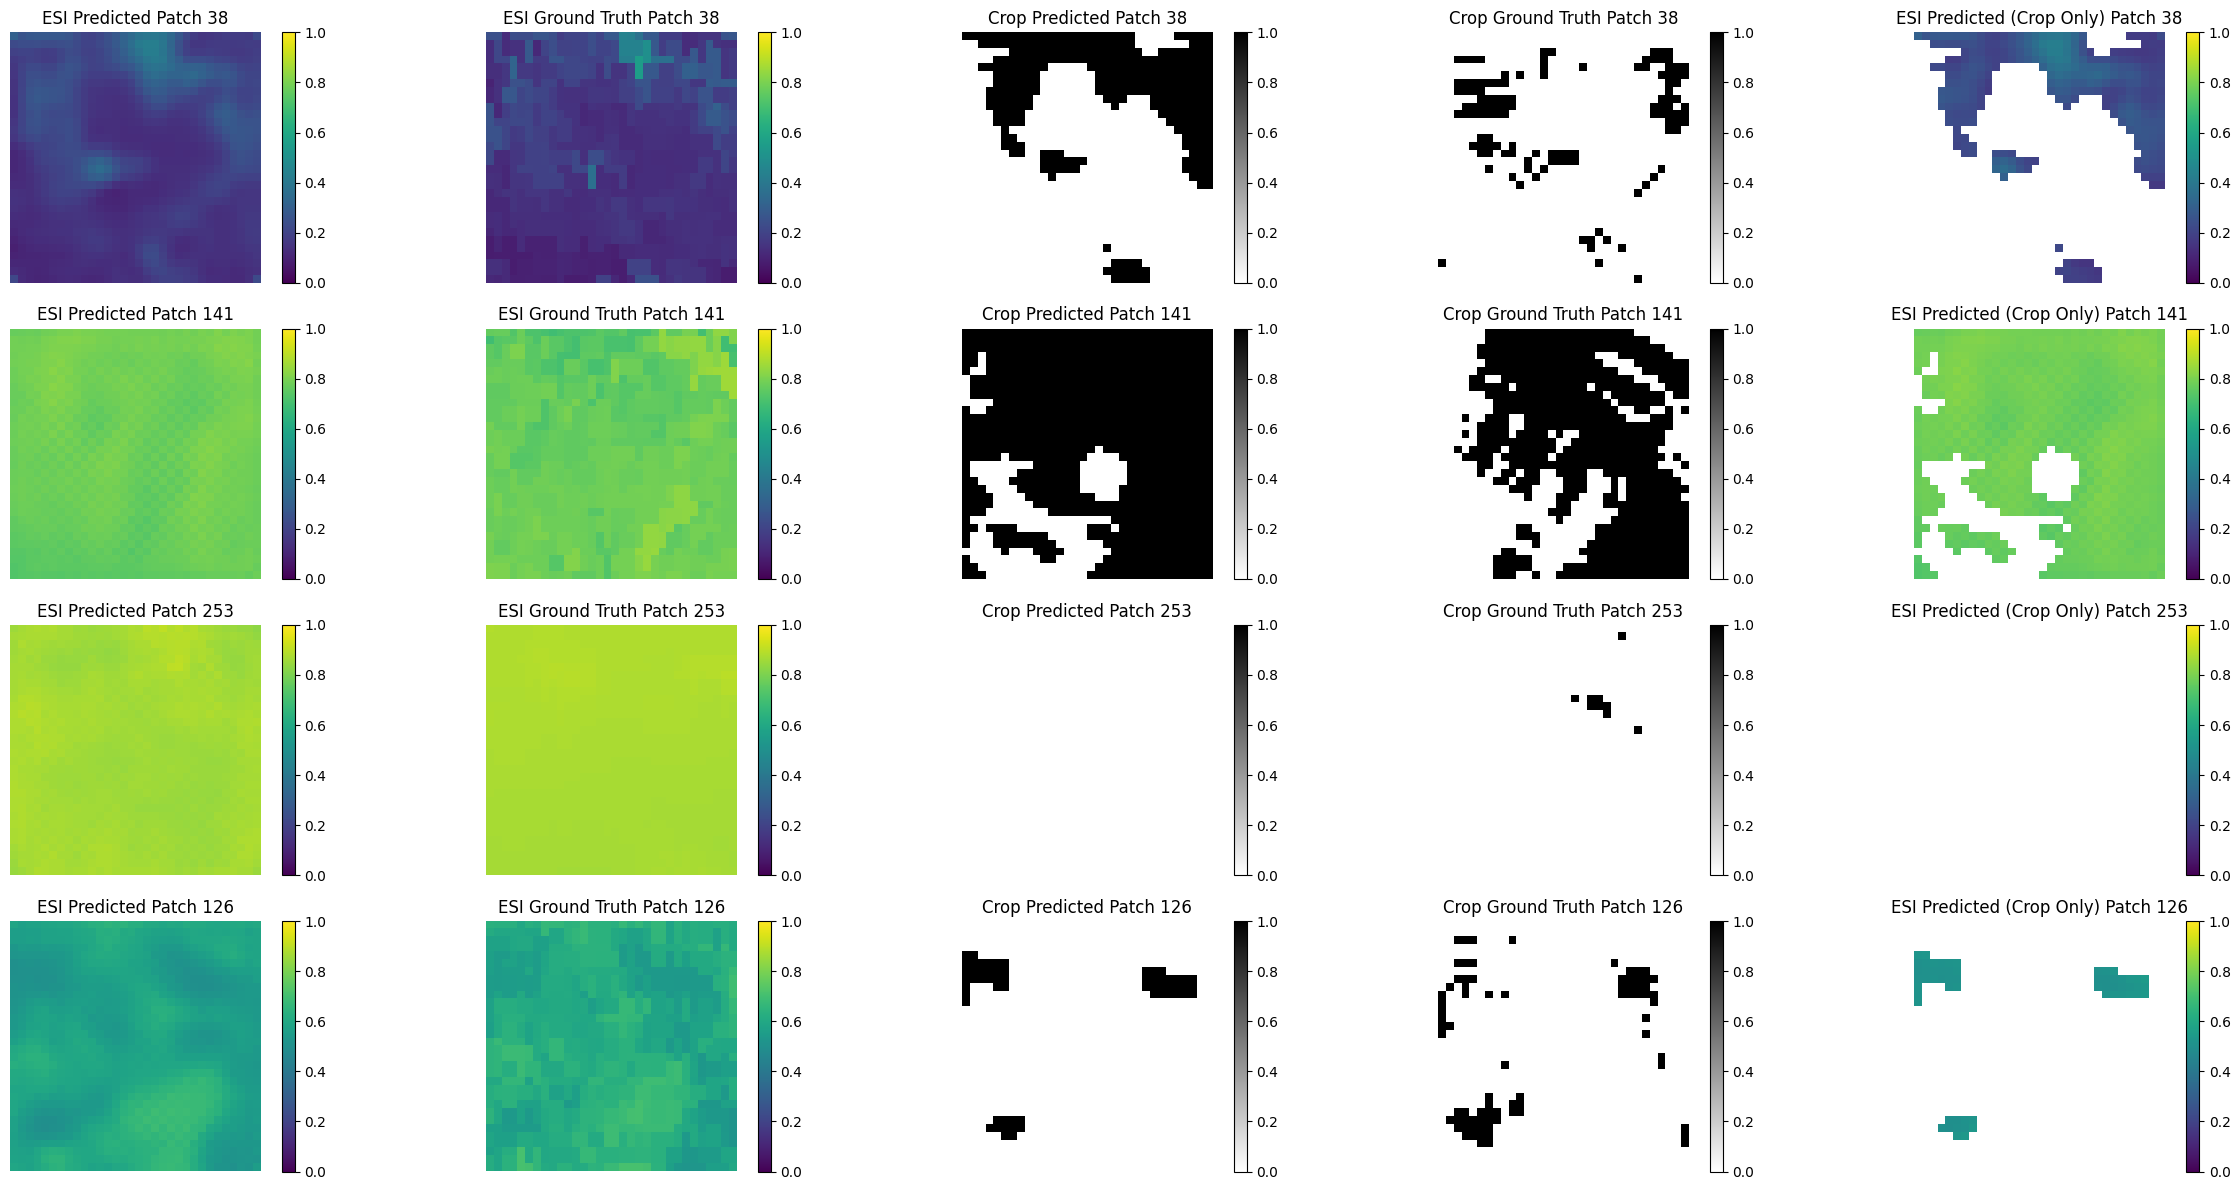

In [18]:
# Randomly sample 4 unique indices
random_indices = torch.randperm(len(outputs[1]))[:4]

# Extract matching patches based on random indexes
esi_predicted = outputs[1][random_indices].squeeze().cpu().numpy()
crop_predicted = max_prob_classes[random_indices].cpu().numpy()

esi_ground_truth = y2_test[random_indices].squeeze().cpu().numpy()
crop_ground_truth = y1_test[random_indices].cpu().numpy()

# Calculate ESI where LULC is "Crop"
esi_predicted_on_crop = esi_predicted * (crop_predicted == 1)

# Create a figure and axes for plotting
fig, axs = plt.subplots(4, 5, figsize=(25, 12))

# Create a custom colormap that displays NaN values as white
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # NaN as white

for i in range(4):
    # ESI Predicted
    im_esi_pred = axs[i, 0].imshow(esi_predicted[i], cmap='viridis', vmin=0, vmax=1)
    axs[i, 0].set_title(f"ESI Predicted Patch {random_indices[i].item() + 1}")
    axs[i, 0].axis('off')
    fig.colorbar(im_esi_pred, ax=axs[i, 0], orientation='vertical', fraction=0.046, pad=0.04)

    # ESI Ground Truth
    im_esi_gt = axs[i, 1].imshow(esi_ground_truth[i], cmap='viridis', vmin=0, vmax=1)
    axs[i, 1].set_title(f"ESI Ground Truth Patch {random_indices[i].item() + 1}")
    axs[i, 1].axis('off')
    fig.colorbar(im_esi_gt, ax=axs[i, 1], orientation='vertical', fraction=0.046, pad=0.04)

    # Crop Predicted
    im_crop_pred = axs[i, 2].imshow(crop_predicted[i], cmap='gray_r', vmin=0, vmax=1)
    axs[i, 2].set_title(f"Crop Predicted Patch {random_indices[i].item() + 1}")
    axs[i, 2].axis('off')
    fig.colorbar(im_crop_pred, ax=axs[i, 2], orientation='vertical', fraction=0.046, pad=0.04)

    # Crop Ground Truth
    im_crop_gt = axs[i, 3].imshow(crop_ground_truth[i], cmap='gray_r', vmin=0, vmax=1)
    axs[i, 3].set_title(f"Crop Ground Truth Patch {random_indices[i].item() + 1}")
    axs[i, 3].axis('off')
    fig.colorbar(im_crop_gt, ax=axs[i, 3], orientation='vertical', fraction=0.046, pad=0.04)

    # ESI Predicted on Crop
    im_esi_crop_pred = axs[i, 4].imshow(np.where(crop_predicted[i] == 1, esi_predicted_on_crop[i], np.nan), cmap=cmap, vmin=0, vmax=1)
    axs[i, 4].set_title(f"ESI Predicted (Crop Only) Patch {random_indices[i].item() + 1}")
    axs[i, 4].axis('off')
    fig.colorbar(im_esi_crop_pred, ax=axs[i, 4], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()